In [619]:
%time
!git status

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
On branch master
nothing to commit, working directory clean


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#import keras
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))


data_dictionary.txt
macro.csv
macro.xlsx
sample_submission.csv
test.csv
train.csv
train.xlsx



In [3]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [4]:
import math
import datetime
from sklearn.preprocessing import LabelEncoder

In [5]:
# Загружаем данные. Индексом ставим timestamp.

In [6]:
macro = pd.read_csv('../Data/macro.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
train = pd.read_csv('../Data/train.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
test = pd.read_csv('../Data/test.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [7]:
llist = range(0,185)
##llist = range(-60,90)

roll  = 30
xLU = macro['usdrub'].rolling(roll).mean()
xLE = macro['eurrub'].rolling(roll).mean()

xL1 = (pd.concat([100/(macro.usdrub.shift(i))    for i in llist], axis=1,keys=['L1%s' % i for i in llist])).dropna()
xL2 = (pd.concat([(macro.usdrub.shift(i))**2 for i in llist], axis=1,keys=['L2%s' % i for i in llist])).dropna()
xL3 = (pd.concat([(macro.usdrub.shift(i))**3 for i in llist], axis=1,keys=['L3%s' % i for i in llist])).dropna()
xLL =  pd.concat([xL1,xL2,xL3], axis=1) 
xLL = xL1
##xLL = (pd.concat([(macro.usdrub.shift(i)) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()
xLL.dropna()
del llist
##xLL.head(),xLL.tail()
xLL.shape, xLL.index.min(),xLL.index.max()

((2297, 185),
 Timestamp('2010-07-07 00:00:00', freq='D'),
 Timestamp('2016-10-19 00:00:00', freq='D'))

In [8]:
macro.shape, train.shape, test.shape, xLL.shape

((2484, 99), (30471, 291), (7662, 290), (2297, 185))

In [9]:
# Массивы для перекодировки значений в числовую форму
#ntrain, ntest = pd.concat([train,macro],axis=1,join='inner'), pd.concat([test,macro],axis=1,join='inner')

ntrain, ntest, nmacro = train.copy(), test.copy(), macro.copy()

print('macro=',macro.index.min(),macro.index.max())
print('train=',train.index.min(),train.index.max())
print('test =',test.index.min(),test.index.max())
print('xLL =',xLL.index.min(),xLL.index.max())
print 'macro=', macro.shape, 'ntrain=', ntrain.shape, 'ntest=', ntest.shape, 'xLL=', xLL.shape

('macro=', Timestamp('2010-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00'))
('train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('test =', Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00'))
('xLL =', Timestamp('2010-07-07 00:00:00', freq='D'), Timestamp('2016-10-19 00:00:00', freq='D'))
macro= (2484, 99) ntrain= (30471, 291) ntest= (7662, 290) xLL= (2297, 185)


In [10]:
# Очистка данных: убираем пустоты в ntrain: max_floor, num_room, kitch_sq

In [11]:
print(ntrain.shape)
ntrain = ntrain[ntrain.max_floor.notnull()]
ntrain = ntrain[ntrain.num_room.notnull()]
ntrain = ntrain[ntrain.kitch_sq.notnull()]
ntrain.shape

(30471, 291)


(20899, 291)

In [12]:
def clear_datas (data) :
    
    # clear life_sq
    data['life_sq'].dropna(0);
    
    while (data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)].count()>0) :
        data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)] /= 10.0;

    iid = data[data.life_sq>data.full_sq].index
    data.ix[iid,'life_sq'] = data.ix[iid,'full_sq'];
    
    data.loc[(data.kitch_sq>1000)|(data.kitch_sq>data.life_sq)] = np.NAN
    
    return

In [13]:
# Убираем индекс, переходим на нумерацию для простоты
ntrain = ntrain.reset_index()
ntest  = ntest.reset_index()
nmacro = nmacro.reset_index()
xLL    = xLL.reset_index()
dict_col_le = {}

In [14]:
# Сериализация символьных значений

In [15]:
dict_col_le = {}
for cc in ntrain.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    ntrain[cc] = ntrain[cc].fillna('NANA')
    ntest[cc]  = ntest[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(ntrain[cc].values.astype('str')) + list(ntest[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    ntrain[cc] = le.transform(list(ntrain[cc].values.astype('str')))
    ntest[cc]  = le.transform(list(ntest[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
for cc in nmacro.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    nmacro[cc] = nmacro[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(nmacro[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    nmacro[cc] = le.transform(list(nmacro[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
# Добиваем пустоты
ntrain = ntrain.fillna(0)
ntest  = ntest.fillna(0)
nmacro = nmacro.fillna(0)

In [16]:
dict_col_le.keys()
#ntrain.child_on_acc_pre_school.unique()
#ntest.child_on_acc_pre_school.unique()
#dict_col_le['sub_area'].inverse_transform(ntrain.sub_area.unique())

['railroad_terminal_raion',
 'oil_chemistry_raion',
 'culture_objects_top_25',
 'product_type',
 'sub_area',
 'modern_education_share',
 'incineration_raion',
 'detention_facility_raion',
 'thermal_power_plant_raion',
 'radiation_raion',
 'old_education_build_share',
 'railroad_1line',
 'ecology',
 'big_market_raion',
 'water_1line',
 'nuclear_reactor_raion',
 'big_road1_1line',
 'child_on_acc_pre_school']

In [17]:
# Дополнение train полями usd, eur и расчет дополнительных результативных полей в train (стоимость м2 в usd и eur для жилой и общей площади)

In [18]:
def add_datetime (data) :
    data['day']     = data.timestamp.dt.day  
    data['month']   = data.timestamp.dt.month
    data['year']    = data.timestamp.dt.year
    data['week']    = data.timestamp.dt.week
    data['weekday'] = data.timestamp.dt.weekday
    
    month_year = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    data['year_month_cnt'] = month_year.map(month_year_cnt_map)
    data['year_month']     = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
    
    week_year = (data.timestamp.dt.week + data.timestamp.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    data['year_week_cnt'] = week_year.map(week_year_cnt_map)
    data['year_week']     = (data.timestamp.dt.week + data.timestamp.dt.year * 100)
    
    return

def add_features_1 (data) :
    
    #data = data.reset_index()
    
    data['build_year0']   = data.build_year;
    data.ix[data.build_year<=1500,'build_year0']=data.ix[data.build_year<=1500,'year']-2;
    
    data['full0']         = data.full_sq; data.ix[data.full_sq<=1,'full0']=50.0
    data['life0']         = data.life_sq; data.ix[data.life_sq<=1,'life0']=data.ix[data.life_sq<=1,'full0']; 
    data.ix[data.life_sq>data.full_sq,'life0'] = data.ix[data.life_sq>data.full_sq,'full0']
    
    data['floor0']        = data.floor;     data.ix[data.floor<1,'floor0']=1.0;
    data['max_floor0']    = data.max_floor; 
    data.ix[data.max_floor0<data.floor0,'max_floor0']=data.ix[data.max_floor0<data.floor0,'floor0'];
    
    data.ix[data.kitch_sq>data.life0,'kitch_sq'] = data.ix[data.kitch_sq>data.life0,'life0']
    
    data.num_room.loc[data.num_room<1] = 1
    
    data['floor:max']     = data.floor0/data.max_floor0  
    data['max-floor']     = data.max_floor0-data.floor0
    data['kitch:full']    = data.kitch_sq/data.full0
    data['life:full']     = data.life0/data.full0
    data['full:room']     = data.full0/data.num_room
    data['life:room']     = data.life0/data.num_room
    data['full-life']     = data.full0-data.life0
    data['build-year']    = data.build_year0-data.year
    
    #data = data.set_index('timestamp')
    
    return(data)


In [19]:
ttrain, ttest = ntrain.copy(), ntest.copy();

add_datetime(ttrain)
add_datetime(ttest)

add_features_1(ttrain)
add_features_1(ttest)

trainUsdEur = pd.merge(ttrain[['timestamp','price_doc','full0','life0']],nmacro[['timestamp','eurrub','usdrub']],on='timestamp',how='inner')
testUsdEur  = pd.merge(ttest [['timestamp','full0','life0']],nmacro[['timestamp','eurrub','usdrub']],on='timestamp',how='inner')

trainUsdEur['usdm2full'] = trainUsdEur.price_doc/(trainUsdEur.usdrub*trainUsdEur.full0)
trainUsdEur['usdm2life'] = trainUsdEur.price_doc/(trainUsdEur.usdrub*trainUsdEur.life0)

if False :
    ttrain['usd']=ttrain.price_doc/ttrain.usdrub; 
    ttrain['eur']=ttrain.price_doc/ttrain.eurrub

    ttrain['usdm2full'] = ttrain.usd/(ttrain.full0)
    ttrain['usdm2life'] = ttrain.usd/(ttrain.life0)

    usdm2Max = 7000
    usdm2Min = 1000

    ttrain = ttrain[ttrain.usdm2full<=usdm2Max]
    ttrain = ttrain[ttrain.usdm2full>=usdm2Min]

    ttrain['eurm2full'] = ttrain.eur/(ttrain.full0)
    ttrain['eurm2life'] = ttrain.eur/(ttrain.life0)

    #ttrain['full_life'], ttest['full_life'] = (ttrain.full_sq+1)/(ttrain.life_sq+1), (ttest.full_sq+1)/(ttest.life_sq+1)

    ttrain['div_eurrub'],  ttest['div_eurrub']  = 1/ttrain.eurrub, 1/ttest.eurrub
    ttrain['div_usdrub'],  ttest['div_usdrub']  = 1/ttrain.usdrub, 1/ttest.usdrub
    ttrain['div_eurrub2'], ttest['div_eurrub2'] = ttrain.div_eurrub**2, ttest.div_eurrub**2
    ttrain['div_usdrub2'], ttest['div_usdrub2'] = ttrain.div_usdrub**2, ttest.div_usdrub**2

    ###ttrain['r']    = np.log1p(ttrain.price_doc) # 2017-05-31 LB = 0.86
    ###ttrain['r']    = np.log1p(ttrain.usdm2full) # 2017-06-02 LB = 0.51
    ###ttrain['r']    = ttrain.usdm2full # 2017-06-02 LB = 0.361
    ###ttrain['r'] = ttrain.price_doc/(ttrain.full_sq+1.0) # # 2017-06-02 LB = 0.41066
    ##ttrain['r'] = ttrain.usdm2life # # 2017-06-02 LB = 0.37543
#######################################################################################################

coef = 1.0 # 0.969
#ttrain['r'] = ttrain.price_doc # ttrain.usdm2full*coef 
##ttrain['r'] = ttrain.price_doc/ttrain.life0 # 2017-06-22 better = 0.31770
##ttrain['r'] = ttrain.price_doc*ttrain['life:full']/ttrain.full0 # 2017-06-23
##ttrain['r'] = trainUsdEur.usdm2full # 2017-06-24
#ttrain['r'] = ttrain.price_doc # 2017-06-25 best results 0.3195

ttrain['r'] = ttrain.price_doc/ttrain.full0 # 2017-06-25 LB=0.31640 
#ttrain['r'] = ttrain.price_doc*2/(ttrain.full0+ttrain.life0) # 2017-06-25 LB= 0.31726 (only full0 better)
##ttrain['r'] = ttrain.price_doc*ttrain['life:full']/ttrain.full0 # 2017-06-25 LB=0.31994
#######################################################################################################

print(train.shape,ttrain.shape,test.shape,ttest.shape) #,llist)
ttrain.head()

((30471, 291), (20899, 315), (7662, 290), (7662, 313))


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,max_floor0,floor:max,max-floor,kitch:full,life:full,full:room,life:room,full-life,build-year,r
0,2013-04-27,7675,73,36.0,17.0,17.0,1.0,0.0,2.0,11.0,...,17.0,1.000000,0.0,0.150685,0.493151,36.500000,18.000000,37.0,-2.0,138356.164384
1,2013-05-21,8059,11,11.0,2.0,5.0,2.0,1907.0,1.0,11.0,...,5.0,0.400000,3.0,1.000000,1.000000,11.000000,11.000000,0.0,-106.0,250000.000000
2,2013-05-23,8114,85,0.0,13.0,22.0,4.0,0.0,3.0,0.0,...,22.0,0.590909,9.0,0.000000,1.000000,28.333333,28.333333,0.0,-2.0,89111.717647
3,2013-05-25,8138,53,30.0,10.0,16.0,1.0,1980.0,2.0,8.0,...,16.0,0.625000,6.0,0.150943,0.566038,26.500000,15.000000,23.0,-33.0,169811.320755
4,2013-05-27,8147,41,37.0,13.0,17.0,1.0,0.0,1.0,1.0,...,17.0,0.764706,4.0,0.024390,0.902439,41.000000,37.000000,4.0,-2.0,108717.073171


In [20]:
# clearning small price
ttrain = ttrain[ttrain.r>=50000]

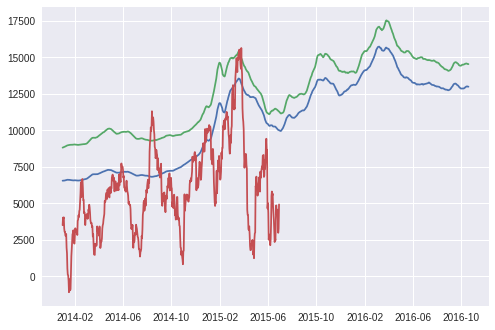

In [22]:
roll, roll1, shiftUE, poly  = 14,30,40,12
xLU = macro['usdrub'].rolling(roll).mean().dropna().shift(shiftUE)
xLE = macro['eurrub'].rolling(roll).mean().dropna().shift(shiftUE)
rr = ttrain[['r','timestamp']].set_index('timestamp')
rr = rr['r'].resample('D').mean().rolling(roll1,min_periods=1).mean()

#print(xLU.tail())

rue_data = pd.DataFrame();
rue_data['usd'] = xLU;
rue_data['r']  = rr
rue_data['eur']  = xLE
for i in range(2,poly) :
    rue_data['usd'+str(i)] = rue_data.usd**i
    rue_data['eur'+str(i)] = rue_data.eur**i
#print rue_data.tail()

plt.plot(rue_data[(rue_data.index>='2014')]['usd']*200); 
plt.plot(rue_data[(rue_data.index>='2014')]['eur']*200); 
plt.plot(rr[rr.index>='2014']-140000);
plt.show()
xLL = rue_data.copy().drop('r',axis=1); 
xLL = xLL.dropna();
rue_data = rue_data.dropna()
#xLL.head(), xLL.tail()

usd2+eur2+usd3+eur3+usd4+eur4+usd5+eur5+usd6+eur6+usd7+eur7+usd8+eur8+usd9+eur9+usd10+eur10+usd11+eur11
                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     22.07
Date:                Thu, 29 Jun 2017   Prob (F-statistic):           1.43e-36
Time:                        02:16:52   Log-Likelihood:                -7836.9
No. Observations:                 795   AIC:                         1.570e+04
Df Residuals:                     784   BIC:                         1.575e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



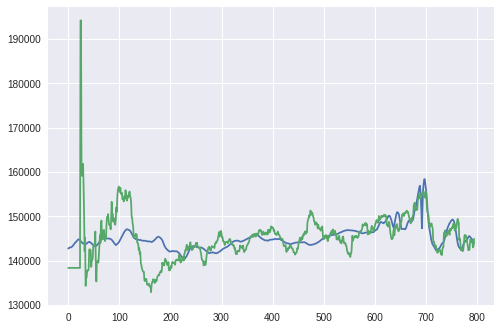

((2428, 2),       timestamp             LL
 2423 2016-10-15  152580.762297
 2424 2016-10-16  152574.582442
 2425 2016-10-17  152228.375587
 2426 2016-10-18  151874.651399
 2427 2016-10-19  151983.775318)

In [23]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

rue2014 = rue_data[rue_data.index>='2013']

rue_f = '+'.join(['usd'+str(i)+'+eur'+str(i) for i in range(2,poly)])
print(rue_f)
rue = sm.OLS.from_formula("r ~ usd+eur+"+rue_f, data=rue2014)
#rue = sm.OLS.from_formula("r ~ usd+eur", data=rue2014)
rue_m  = rue.fit()
print rue_m.summary()

rue = macro[['usdrub','eurrub']]; rue.columns=['usd','eur']

rue.usd = rue.usd.rolling(roll).mean().dropna().shift(shiftUE)
rue.eur = rue.eur.rolling(roll).mean().dropna().shift(shiftUE)
for i in range(2,poly) :
    rue['usd'+str(i)] = rue.usd**i
    rue['eur'+str(i)] = rue.eur**i
xLL = pd.DataFrame(rue_m.predict(rue),columns=['LL'])
rue2014['LL'] = xLL.LL
xLL = xLL.dropna().reset_index()
plt.plot(rue2014['LL'].ravel()); plt.plot(rue2014['r'].ravel()); 
plt.show()
xLL.shape, xLL.tail()


In [24]:
# Начинаем строить модель по остаткам train данных

In [25]:
col_res     = ['r'];
col_notuse  = ['usdm2full','usdm2life','eurm2full','eurm2life','price_doc','id','eur','usd','timestamp']+col_res
##col_notuse += ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year']

### begin 2017-06-04 after

col_notuse += ['build_year0','max_floor0'] #, 'full0'] #, 'life0']  #, 'floor0']
#######col_notuse += ['usdrub','eurrub'] 
col_notuse += ['life_sq','floor','full0']

#col_notuse += ['material'] #'build-year'] # ???????????????????
#col_notuse += ['day','year','week','month'] # ???????????????????   22-06
##col_notuse += ['area_m','sub_area','state'] # ???????????????????  22-06
##col_notuse += ['state'] # ??????????????????? 22-06
##col_notuse += ['full_sq','max_floor'] # ??????????????????? 22-06
#col_notuse += ['state'] # 28-06-2017
#col_notuse += ['build_year'] # 28-06-2017
##col_notuse += ['cafe_sum_500_min_price_avg','cafe_sum_1000_min_price_avg','cafe_sum_2000_min_price_avg'] # 28-06
##col_notuse += ['cafe_sum_1500_min_price_avg','cafe_sum_1000_max_price_avg','cafe_sum_2000_max_price_avg','cafe_sum_500_max_price_avg'] # 28-06
col_notuse += ['hospital_beds_raion'] # 28-06-2017



##################################################################
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if len(ntrain[ntrain.columns[i]].unique())<=1]

col_use    = [ x for x in ttrain.columns.tolist() if x not in col_notuse];


In [26]:
#
#  Процедуры для синхронного построения из массивов (train, test, macro, ll) оценочных массивов (train_x, train_y, test_y)
#     в разных компоновочных вариантах
#

def ttConcat   (train,test,right) :
    train  = train.set_index('timestamp')
    test   = test.set_index('timestamp')
    right  = right.set_index('timestamp')
    
    ntrain, ntest = pd.concat([train,right],axis=1,join='inner'), pd.concat([test,right],axis=1,join='inner')
    
    train  = train.reset_index()
    test   = test.reset_index()
    right  = right.reset_index()
    
    ntrain = ntrain.reset_index()
    ntest  = ntest.reset_index()
    
    return ntrain, ntest

def pd1   (col_notuse,col_res,train,test) :
    col_use    = [ x for x in train.columns.tolist() if x not in col_notuse];
    return train[col_use],train[col_res],test[col_use]

def pd1m  (col_notuse,col_res,train,test,macro) :
    ntrain, ntest = ttConcat(train,test,macro)
    return pd1(col_notuse,col_res,ntrain,ntest)

def pd1l  (col_notuse,col_res,train,test,ll) :
    ntrain, ntest = ttConcat(train,test,ll)
    return pd1(col_notuse,col_res,ntrain,ntest)

def pd1ml (col_notuse,col_res,train,test,macro,ll) :
    print train.shape, test.shape
    ntrain, ntest = ttConcat(train,test,macro)
    print ntrain.shape, ntest.shape
    ntrain, ntest = ttConcat(ntrain,ntest,ll)
    print ntrain.shape, ntest.shape
    return pd1(col_notuse,col_res,ntrain,ntest)


In [27]:
#col_notuse = col_notuse + ffs.index[ffs.imp<250].values.tolist()
#train_x, train_y, test_x  = pd1ml (col_notuse,col_res,ttrain,ttest,nmacro,xLL)
#train_x, train_y, test_x  = pd1m (col_notuse,col_res,ttrain,ttest,nmacro)
#train_x, train_y, test_x  = pd1l (col_notuse,col_res,ttrain,ttest,xLL)
train_x, train_y, test_x  = pd1 (col_notuse,col_res,ttrain,ttest)
#train_x, train_y, test_x  = pd1l (col_notuse,col_res,ttrain,ttest,xLL)

print train.shape, train_x.shape, train_y.shape, test.shape, test_x.shape

(30471, 291) (19619, 305) (19619, 1) (7662, 290) (7662, 305)


In [28]:
#col_not_use_imp.tolist()
#col_notuse

In [29]:
# Не проходит, нет результативности # train_y.r  /= train_x.LL;

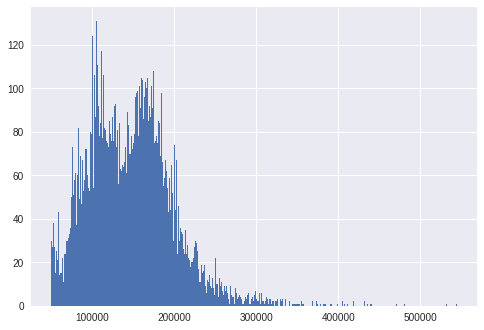

In [30]:
plt.hist(train_y[10000:].r.ravel(),bins=400); plt.show()
#plt.plot(macro.usdrub); plt.show()
#plt.plot(train_y[16000:]); plt.show()

In [31]:
print len(train),len(train_x)

30471 19619


In [32]:
import xgboost as xgb

def rmsle(preds, dtrain, dmatrix=True):
    if dmatrix : labels = dtrain.get_label()
    else : labels = dtrain
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return 'rmsle', logs2

def rmsleSK(ground_true, preds):
    labels = ground_true
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return -logs2

def xgbCVtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    history = xgb.cv(param, dtrain, verbose_eval=10, 
                     metrics=['rmse'],feval=rmsle,
                     num_boost_round=num_round,nfold=5,early_stopping_rounds=stopping) 
    rvalid={}
    bst    = xgb.train(param, dtrain, history['test-rmsle-mean'].argmin()+2, watchlist, evals_result=rvalid, feval=rmsle)
    #bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=rvalid, early_stopping_rounds=stopping)
    return(bst,np.array(rvalid['valid']['rmse']))


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
# Строим основные массивы
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest  = xgb.DMatrix(test_x)

In [34]:
#dtrainCV = xgb.DMatrix(train_x,label=train_y)
train_week_begin = 201400
train_week_tail  = 201500
train_xx    = train_x[train_x.year_week>=train_week_begin]
#train_xx_ll = train_xx.LL; 
#train_xx = train_xx.drop('LL',axis=1)
train_yy    = train_y[train_x.year_week>=train_week_begin]
dtrainCV    = xgb.DMatrix(train_xx,label=train_yy)
train_xx15  = train_x[train_x.year_week>=train_week_tail]
#train_xx15_ll = train_xx15.LL; 
#train_xx15 = train_xx15.drop('LL',axis=1)
train_yy15  = train_y[train_x.year_week>=train_week_tail]
dtrainCV2015= xgb.DMatrix(train_xx15,label=train_yy15)
train_x.shape, train_y.shape, train_xx.shape, train_yy.shape, train_xx15.shape, train_yy15.shape

((19619, 305), (19619, 1), (15924, 305), (15924, 1), (3100, 305), (3100, 1))

In [35]:
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
##param = {'silent':0, 'objective':'reg:linear', 'eta':0.05, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':15, 'subsample':0.16, 'colsample_bytree':0.9399, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.05, 'max_depth':5, 'subsample':0.7, 'colsample_bytree':0.7, 'metrics':'rmse'}
# CV sklearn
param = {'silent':0, 'objective':'reg:linear', 'eta':0.005, 
         'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         'metrics':'rmse'}
'''
param = {'silent':0, 'objective':'reg:linear', 'eta':0.01, 
         'max_depth':9, 'subsample':0.85, 'colsample_bytree':0.8, 
         'min_child_weight':12.0,
         'tree_method':'exact',
         'metrics':'rmse'}
'''
history = xgb.cv(param, dtrainCV, verbose_eval=10, metrics=['rmse'],feval=rmsle,num_boost_round=1500,nfold=5,early_stopping_rounds=20) #,stratified=True,maximize=True)

[0]	train-rmsle:5.29314+0.00142693	test-rmsle:5.29921+0.00723637
[10]	train-rmsle:2.91749+0.000555688	test-rmsle:2.92038+0.00404728
[20]	train-rmsle:2.29701+0.000332315	test-rmsle:2.30056+0.00412394
[30]	train-rmsle:1.93357+0.000332433	test-rmsle:1.93752+0.00432536
[40]	train-rmsle:1.67962+0.000300123	test-rmsle:1.68406+0.00426962
[50]	train-rmsle:1.48674+0.000198016	test-rmsle:1.49175+0.00398304
[60]	train-rmsle:1.33287+0.000188165	test-rmsle:1.33843+0.00401493
[70]	train-rmsle:1.20602+0.000118053	test-rmsle:1.21212+0.00392412
[80]	train-rmsle:1.09896+0.000124683	test-rmsle:1.10563+0.00393645
[90]	train-rmsle:1.00708+0.000124636	test-rmsle:1.01442+0.00387954
[100]	train-rmsle:0.927177+0.000123905	test-rmsle:0.935143+0.00385549
[110]	train-rmsle:0.856925+0.000146842	test-rmsle:0.865649+0.00382159
[120]	train-rmsle:0.794631+0.000140577	test-rmsle:0.804102+0.00375665
[130]	train-rmsle:0.739009+0.000146034	test-rmsle:0.749288+0.00366668
[140]	train-rmsle:0.689048+0.000169629	test-rmsle:0.

In [36]:
watchlistCV  = [(dtrainCV,'train')]
rvalidCV = {}
bstCV = xgb.train(param, dtrainCV, history['test-rmsle-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV, feval=rmsle)
##bstCV = xgb.train(param, dtrainCV, history['test-rmse-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV)

train_cv = bstCV.predict(dtrainCV)
train_cv = np.abs(train_cv)
_,train_rmsle_CV     = rmsle(train_cv,dtrainCV)

train_cv_tail = bstCV.predict(dtrainCV2015)
train_cv_tail = np.abs(train_cv_tail)
_,train_rmsle_CV2015 = rmsle(train_cv_tail,dtrainCV2015)

if False :
    bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=1800, stopping=30, ratio=0.9)

    train_cv = bst.predict(dtrainCV,ntree_limit=rvalid_log.argmin())
    train_cv = np.abs(train_cv)
    _,train_rmsle = rmsle(train_cv,dtrainCV)

[0]	train-rmsle:5.29255
[1]	train-rmsle:4.59986
[2]	train-rmsle:4.1959
[3]	train-rmsle:3.91102
[4]	train-rmsle:3.69091
[5]	train-rmsle:3.51079
[6]	train-rmsle:3.35909
[7]	train-rmsle:3.22816
[8]	train-rmsle:3.11302
[9]	train-rmsle:3.01027
[10]	train-rmsle:2.91757
[11]	train-rmsle:2.83316
[12]	train-rmsle:2.75575
[13]	train-rmsle:2.68421
[14]	train-rmsle:2.61775
[15]	train-rmsle:2.55587
[16]	train-rmsle:2.49774
[17]	train-rmsle:2.44311
[18]	train-rmsle:2.39152
[19]	train-rmsle:2.34288
[20]	train-rmsle:2.29667
[21]	train-rmsle:2.25276
[22]	train-rmsle:2.21094
[23]	train-rmsle:2.17096
[24]	train-rmsle:2.13272
[25]	train-rmsle:2.09612
[26]	train-rmsle:2.06103
[27]	train-rmsle:2.02721
[28]	train-rmsle:1.99475
[29]	train-rmsle:1.96343
[30]	train-rmsle:1.93321
[31]	train-rmsle:1.90408
[32]	train-rmsle:1.87588
[33]	train-rmsle:1.84861
[34]	train-rmsle:1.82214
[35]	train-rmsle:1.79654
[36]	train-rmsle:1.77167
[37]	train-rmsle:1.74755
[38]	train-rmsle:1.72417
[39]	train-rmsle:1.70139
[40]	train-

In [37]:
# LL - 88
import sklearn.metrics as skme
#print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
print ' cv={}, er={}, er-tail={},\n R2={}, R2(tail)={},\n mae={}, mae-tail={},\n mse={}, mse-tail={}'.format(history['test-rmsle-mean'].min(),train_rmsle_CV, train_rmsle_CV2015, 
                                                                    skme.r2_score(dtrainCV.get_label(),train_cv), 
                                                                    skme.r2_score(dtrainCV2015.get_label(),train_cv_tail),
                                                                    skme.mean_absolute_error(dtrainCV.get_label(),train_cv),
                                                                    skme.mean_absolute_error(dtrainCV2015.get_label(),train_cv_tail),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV.get_label(),train_cv)),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV2015.get_label(),train_cv_tail))
                                                                   )
#plt.plot(history['test-rmsle-mean']); plt.show()

 cv=0.2042224, er=0.12558978796, er-tail=0.123455449939,
 R2=0.917495769741, R2(tail)=0.924077871868,
 mae=9578.84863281, mae-tail=10030.7109375,
 mse=14583.0097656, mse-tail=14776.9316406


In [608]:
import sklearn.metrics as skme
#print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
print ' cv={}, er={}, er-tail={},\n R2={}, R2(tail)={},\n mae={}, mae-tail={},\n mse={}, mse-tail={}'.format(history['test-rmsle-mean'].min(),train_rmsle_CV, train_rmsle_CV2015, 
                                                                    skme.r2_score(dtrainCV.get_label(),train_cv), 
                                                                    skme.r2_score(dtrainCV2015.get_label(),train_cv_tail),
                                                                    skme.mean_absolute_error(dtrainCV.get_label(),train_cv),
                                                                    skme.mean_absolute_error(dtrainCV2015.get_label(),train_cv_tail),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV.get_label(),train_cv)),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV2015.get_label(),train_cv_tail))
                                                                   )
#plt.plot(history['test-rmsle-mean']); plt.show()

 cv=0.4342192, er=0.337808847427, er-tail=0.295667588711,
 R2=0.752146309817, R2(tail)=0.77434749374,
 mae=19744.1621094, mae-tail=19433.7421875,
 mse=27941.2539062, mse-tail=27258.2558594


 cv=0.4342822, er=0.338776051998, er-tail=0.297612071037,
 R2=0.746525826001, R2(tail)=0.766868924866,
 mae=20100.1367188, mae-tail=19826.8378906,
 mse=28256.2851562, mse-tail=27706.2714844


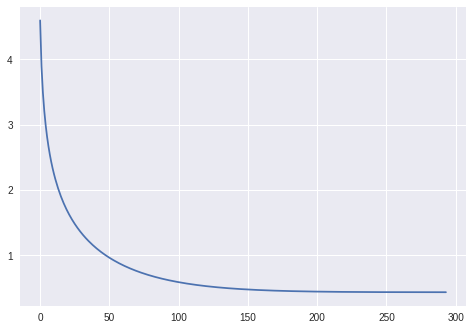

In [605]:
import sklearn.metrics as skme
#print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
print ' cv={}, er={}, er-tail={},\n R2={}, R2(tail)={},\n mae={}, mae-tail={},\n mse={}, mse-tail={}'.format(history['test-rmsle-mean'].min(),train_rmsle_CV, train_rmsle_CV2015, 
                                                                    skme.r2_score(dtrainCV.get_label(),train_cv), 
                                                                    skme.r2_score(dtrainCV2015.get_label(),train_cv_tail),
                                                                    skme.mean_absolute_error(dtrainCV.get_label(),train_cv),
                                                                    skme.mean_absolute_error(dtrainCV2015.get_label(),train_cv_tail),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV.get_label(),train_cv)),
                                                                    np.sqrt(skme.mean_squared_error(dtrainCV2015.get_label(),train_cv_tail))
                                                                   )
plt.plot(history['test-rmsle-mean']); plt.show()

In [216]:
print '%s))' % '123'

123))


In [56]:
import sklearn.metrics as skme
import sklearn.model_selection as skms

#cvtest_param  = {'max_depth':range(5,19,2),'subsample':[0.3,0.5,0.7,0.8], 'colsample_bytree':[0.6,0.7,0.8,0.9,0.99]}
cvtest_param  = {'max_depth':[9],'subsample':[0.725,0.75,0.775,0.8,0.825,0.85,0.875], 'colsample_bytree':[0.8]}
cvtest_param  = {'max_depth':[9],'subsample':[0.85], 'colsample_bytree':[0.725,0.75,0.775,0.8,0.825,0.85,0.875]}
cvtest_param  = {'max_depth':[9],'subsample':[0.85], 'colsample_bytree':[0.8],
                 #'tree_method':['exact'],
                 'min_child_weight':[float(i) for i in range(11,14,1)]}

rmsleScorer   = skme.make_scorer(rmsleSK)
cvtest_search = skms.GridSearchCV(estimator = xgb.XGBRegressor( learning_rate=0.05, n_estimators=200), 
                                  param_grid = cvtest_param, n_jobs=1, cv=5, verbose=3, scoring=rmsleScorer)
print train_xx.shape, train_yy.shape
#cvtest_search.fit(train_xx,train_yy,eval_metric=[rmsle],early_stopping_rounds=20)
cvtest_search.fit(train_xx,train_yy.values)
cvtest_search.grid_scores_, cvtest_search.best_params_, cvtest_search.best_score_

(16901, 307) (16901, 1)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.594102, total=   9.9s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.605000, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s


[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.600351, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.573735, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=11.0, score=-0.574877, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0, score=-0.592932, total=   9.9s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0, score=-0.604719, total=  10.0s
[CV] subsample=0.85, colsample_bytree=0.8, max_depth=9, min_child_weight=12.0 
[CV]  subsample=0.85, colsample_bytree=0.8, max_de

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.7min finished
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58961, std: 0.01297, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 11.0},
  mean: -0.58869, std: 0.01302, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 12.0},
  mean: -0.58942, std: 0.01226, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 13.0}],
 {'colsample_bytree': 0.8,
  'max_depth': 9,
  'min_child_weight': 12.0,
  'subsample': 0.85},
 -0.5886864544237006)

In [57]:
cvtest_search.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=12.0, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.85)

In [38]:
###############################################################

In [39]:
# Строим результат

In [40]:
#test_x_ll = test_x.LL; test_x = test_x.drop('LL',axis=1)
dtest = xgb.DMatrix(test_x)
#test_p = bst.predict(dtest,ntree_limit=rvalid_log.argmin())
test_p = bstCV.predict(dtest)
#test_p = bst.predict(dtest)
test_p = np.abs(test_p)
#test_x['LL'] = test_x_ll

In [41]:
test_r = pd.DataFrame(ttest[['id']]); 
##test_r['price_doc']=np.expm1(test_p)*(test_x.full_sq+1)*test_x.usdrub # 2017-06-02 LB = 0.54
##test_r['price_doc'] = test_p*(test_x.full_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.361
##test_r['price_doc'] = test_p*(test_x.full_sq+1); # 2017-06-02 LB = 0.41066
##test_r['price_doc'] = test_p*(test_x.life_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.39

#test_r['price_doc'] = test_p*test_x.life0*test_x.usdrub; # 2017-06-02 LB = 0.37543
#test_r['price_doc'] = test_p*ttest.full0*ttest.usdrub; # 2017-06-02 LB = 0.37296
#test_r['price_doc'] = test_p # 2017-06-21 LB = 0.31954
#test_r['price_doc'] = test_p*test_x.life0 # 2017-06-24 LB = 0.31770 
#test_r['price_doc'] = test_p*ttest.full0/ttest['life:full'] # 2017-06-22 LB = 0.34990 ????
#test_r['price_doc'] = test_p*testUsdEur.full0*testUsdEur.usdrub # 2017-06-22 LB = 0.34990 ????

test_r['price_doc'] = test_p*testUsdEur.full0 # 2017-06-25 LB = 0.31640
##test_r['price_doc'] = test_p*(testUsdEur.full0+testUsdEur.life0)/2 # 2017-06-25 LB = 0.31726 (worst) 
##test_r['price_doc'] = test_p*testUsdEur.full0/ttest['life:full'] # 2017-06-25 LB = 0.31991
#test_r['price_doc'] = test_p*testUsdEur.full0*test_x.LL # 2017-06-26 LB >0.32

print test_r.price_doc.min(),test_r.price_doc.max(),train.price_doc.min(),train.price_doc.max() 
test_r.head(8)
#test_r.tail(8)
#test_r.shape

246056.84375 82307630.6406 100000 111111112


,id,price_doc
0,30474,5.691988e+06
1,30475,8.773751e+06
2,30476,5.992364e+06
3,30477,6.596281e+06
4,30478,5.298808e+06
5,30479,9.507435e+06
6,30480,4.523006e+06
7,30481,4.423266e+06


In [42]:
ntest[test_r.price_doc<0.0]

,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000


In [43]:
# Результат в файл

In [45]:
test_r[['id','price_doc']].to_csv('../Result/res-92.csv',index=False)

In [46]:
test0 = pd.read_csv('../Result/res-85.csv')
test1 = pd.read_csv('../Result/res-92.csv')
test2 = pd.read_csv('../Result/res-75.csv')
test_rmsle = rmsle(test1.price_doc,test2.price_doc,dmatrix=False)
print rmsle(test0.price_doc,test1.price_doc,dmatrix=False), skme.r2_score(test0.price_doc,test1.price_doc), skme.mean_absolute_error(test0.price_doc,test1.price_doc)
print rmsle(test0.price_doc,test2.price_doc,dmatrix=False), skme.r2_score(test0.price_doc,test2.price_doc), skme.mean_absolute_error(test0.price_doc,test2.price_doc)
print rmsle(test1.price_doc,test2.price_doc,dmatrix=False), skme.r2_score(test1.price_doc,test2.price_doc), skme.mean_absolute_error(test1.price_doc,test2.price_doc)
print rmsle(test2.price_doc,test1.price_doc,dmatrix=False), skme.r2_score(test2.price_doc,test1.price_doc), skme.mean_absolute_error(test2.price_doc,test1.price_doc)

('rmsle', 0.11319015683212226) 0.937004504847 750507.174268
('rmsle', 0.037918511181292539) 0.991651299392 179399.381886
('rmsle', 0.12831925511092176) 0.931470194626 838273.157237
('rmsle', 0.12831925511092176) 0.915058712656 838273.157237


In [406]:
#-------------------------------------------------------------------------------------------

In [47]:
fff = bstCV.get_fscore()
fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
ffs = fff.sort_values('imp')
print ffs.ix[['full_sq','LL','material','day','year','month','week']]
ffs.tail(60)
#ffs.head(60)
#ffs[-120:-60]

              imp
full_sq   20915.0
LL            NaN
material   2499.0
day        3355.0
year        210.0
month      1886.0
week       2075.0


,imp
nuclear_reactor_km,1090
university_km,1099
zd_vokzaly_avto_km,1103
power_transmission_line_km,1106
incineration_km,1149
swim_pool_km,1158
ts_km,1178
big_church_km,1239
max-floor,1239
workplaces_km,1249


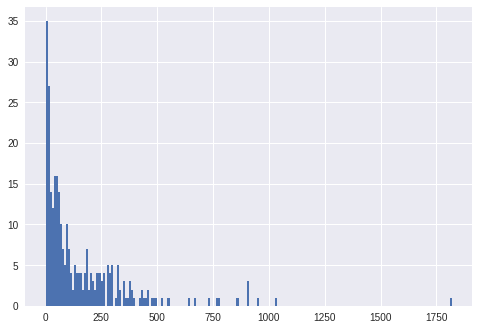

In [535]:
plt.hist(ffs.imp,bins=200); plt.show()

In [204]:
col_not_use_imp = ffs.index[ffs.imp<250].values.tolist()
print(len(col_not_use_imp ))
col_not_use_imp

228


['young_male',
 'mosque_count_2000',
 '0_13_all',
 'mosque_count_500',
 'build_count_foam',
 '0_17_female',
 '0_13_female',
 'big_market_raion',
 'nuclear_reactor_raion',
 '7_14_all',
 'university_top_20_raion',
 '0_6_all',
 'big_church_count_500',
 '7_14_female',
 'railroad_1line',
 'cafe_count_2000_price_high',
 'build_count_mix',
 'culture_objects_top_25_raion',
 '7_14_male',
 'thermal_power_plant_raion',
 'water_1line',
 'trc_count_500',
 'cafe_count_1500_price_high',
 'cafe_count_500_price_4000',
 'big_road1_1line',
 'raion_build_count_with_builddate_info',
 '0_17_male',
 '16_29_female',
 '0_6_male',
 'cafe_count_3000_price_high',
 'female_f',
 'detention_facility_raion',
 'work_male',
 'build_count_frame',
 'work_all',
 'young_all',
 'cafe_count_1000_price_high',
 'leisure_count_500',
 'church_count_500',
 'big_church_count_1000',
 '16_29_male',
 'school_education_centers_top_20_raion',
 'market_count_1000',
 'young_female',
 'ID_bus_terminal',
 'culture_objects_top_25',
 'radiat

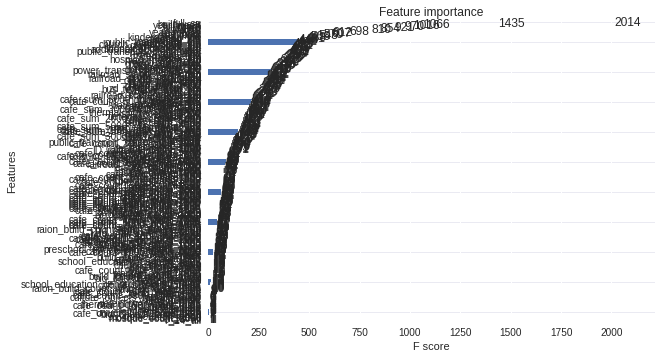

In [409]:
aax = plt.figure(figsize=(16, 16));
xgb.plot_importance(bstCV); 
#xgb.plot_tree(bst); 
plt.show()

In [48]:
#--------- analyze train and test

In [49]:
train_a = ntrain[ntrain.timestamp.dt.year>=2014].describe(include='all').T;
train_a['nulla'] = (len(ntrain)-ntrain.count())/len(train)
train_a['nullb'] = (len(ntrain)-ntrain.count())
test_a  = ntest.describe(include='all').T; test_a
test_a['nulla'] = (len(ntest)-ntest.count())/len(test)
test_a['nullb'] = (len(ntest)-ntest.count())
tt_a    = pd.merge(train_a,test_a,left_index=True,right_index=True, suffixes=('_tr','_te'));

In [50]:
tt_a
tt_a[['mean_tr','mean_te','std_tr','std_te','nulla_tr','nulla_te','nullb_tr','nullb_te']]

,mean_tr,mean_te,std_tr,std_te,nulla_tr,nulla_te,nullb_tr,nullb_te
timestamp,NaN,NaN,NaN,NaN,0.0,0.0,0,0
id,22023,34304.5,4879.04,2211.97,0.0,0.0,0,0
full_sq,54.7207,53.7012,22.7247,20.1043,0.0,0.0,0,0
life_sq,27.4484,27.6472,22.8339,24.0053,0.0,0.0,0,0
floor,7.49837,7.65257,5.2645,5.09942,0.0,0.0,0,0
max_floor,12.5588,12.5911,6.79191,6.65929,0.0,0.0,0,0
material,1.82108,1.85422,1.48126,1.51717,0.0,0.0,0,0
build_year,1510.48,1571.59,848.002,809.798,0.0,0.0,0,0
num_room,1.91237,1.8764,0.849546,0.835665,0.0,0.0,0,0
kitch_sq,6.17916,6.93866,22.2131,25.5797,0.0,0.0,0,0


In [59]:
tt_b = pd.merge(ffs,tt_a,left_index=True,right_index=True); tt_b.sort_values('imp',ascending=False)
#tt_b[(tt_b.nullb_te==0)&(tt_b.nullb_tr>0.0)][['imp','mean_tr','mean_te','std_tr','std_te','nulla_tr','nulla_te','nullb_tr','nullb_te']].sort_values('imp')
#tt_b[(tt_b.nullb_te>0.0)&(tt_b.nullb_tr==0.0)][['imp','mean_tr','mean_te','std_tr','std_te','nulla_tr','nulla_te','nullb_tr','nullb_te']].sort_values('imp')
#tt_b[(tt_b.nullb_te==0)&(tt_b.nullb_tr==0.0)][['imp','mean_tr','mean_te','std_tr','std_te','nulla_tr','nulla_te','nullb_tr','nullb_te']].sort_values('imp')
#tt_b[(tt_b.nullb_te>0.0)&(tt_b.nullb_tr>=0.0)][['imp','mean_tr','mean_te','std_tr','std_te','nulla_tr','nulla_te','nullb_tr','nullb_te']].sort_values('imp')


,imp,count_tr,unique_tr,top_tr,freq_tr,first_tr,last_tr,mean_tr,std_tr,min_tr,...,last_te,mean_te,std_te,min_te,25%_te,50%_te,75%_te,max_te,nulla_te,nullb_te
full_sq,20915,16901,NaN,NaN,NaN,NaN,NaN,54.7207,22.7247,0,...,NaN,53.7012,20.1043,0,39.2,50.41,63.3,403,0.0,0
max_floor,8003,16901,NaN,NaN,NaN,NaN,NaN,12.5588,6.79191,0,...,NaN,12.5911,6.65929,0,9,14,17,48,0.0,0
build_year,6526,16901,NaN,NaN,NaN,NaN,NaN,1510.48,848.002,0,...,NaN,1571.59,809.798,0,1959,1976,2007,2019,0.0,0
kitch_sq,2899,16901,NaN,NaN,NaN,NaN,NaN,6.17916,22.2131,0,...,NaN,6.93866,25.5797,0,1,7,9.5,1968,0.0,0
state,2890,16901,NaN,NaN,NaN,NaN,NaN,1.69984,1.11074,0,...,NaN,1.80593,0.967722,0,1,2,3,4,0.0,0
kindergarten_km,2783,16901,NaN,NaN,NaN,NaN,NaN,1.09529,2.64454,0.000469748,...,NaN,1.10344,2.78198,0.000469748,0.204924,0.38976,0.944998,27.4533,0.0,0
metro_min_avto,2719,16901,NaN,NaN,NaN,NaN,NaN,5.22781,7.06762,0,...,NaN,4.66977,6.14231,0.00902065,1.71766,2.64102,4.61491,65.1011,0.0,0
material,2499,16901,NaN,NaN,NaN,NaN,NaN,1.82108,1.48126,1,...,NaN,1.85422,1.51717,1,1,1,2,6,0.0,0
school_km,2211,16901,NaN,NaN,NaN,NaN,NaN,1.52178,3.70481,0,...,NaN,1.43925,3.5308,0,0.292072,0.51366,0.932718,47.3947,0.0,0
sub_area,2120,16901,NaN,NaN,NaN,NaN,NaN,76.9825,39.3941,0,...,NaN,77.9456,40.2035,0,44,82,108,145,0.0,0


In [8]:
temp=pd.DataFrame(ttrain.columns);

In [9]:
ttrain['sub_area'].unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe', 'Lefortovo',
       "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo", 'Vnukovo',
       'Juzhnoe Tushino', 'Severnoe Tushino', "Chertanovo Central'noe",
       'Fili Davydkovo', 'Otradnoe', 'Novo-Peredelkino', 'Bogorodskoe',
       'Jaroslavskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Staroe Krjukovo', 'Ljublino', 'Caricyno', 'Veshnjaki',
       'Danilovskoe', 'Preobrazhenskoe', "Kon'kovo", 'Brateevo',
       'Vostochnoe Izmajlovo', 'Vyhino-Zhulebino', 'Donskoe',
       'Novogireevo', 'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Ochakovo-Matveevskoe', 'Taganskoe', 'Dmitrovskoe',
       'Orehovo-Borisovo Juzhnoe', 'Teplyj Stan', 'Babushkinskoe',
       'Pokrovskoe Streshnevo', 'Obruc

In [7]:
print(' train=',train.index.min(),train.index.max())
print('ttrain=',ttrain.index.min(),ttrain.index.max())

(' train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('ttrain=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))


In [183]:
acf,confint,qstat,pvalues = sm.tsa.stattools.acf(xtrain,nlags=600,alpha=0.05,qstat=True,fft=True)
#acf
confint.shape #[-10:]
#qstat[-10:]
#pvalues[-10:]
acf[acf>3*confint[:,0]]
#acf.shape, confint.shape
acf[177:185], confint[177:185], qstat[177:185], pvalues[177:185]

(array([ 0.05687618,  0.01495214,  0.01454301,  0.12218533,  0.01729215,
         0.01492026,  0.01349208,  0.01702206]),
 array([[ 0.04518074,  0.06857162],
        [ 0.00322188,  0.02668239],
        [ 0.00281035,  0.02627567],
        [ 0.1104504 ,  0.13392027],
        [ 0.00539791,  0.02918638],
        [ 0.00302285,  0.02681767],
        [ 0.00159232,  0.02539185],
        [ 0.00512036,  0.02892375]]),
 array([ 1404.55727916,  1411.04037485,  1868.68299746,  1877.84943322,
         1884.673916  ,  1890.25462559,  1899.13783036,  1903.71613167]),
 array([  1.93568353e-189,   3.20097876e-190,   2.63858406e-278,
          1.34856387e-279,   1.98803802e-280,   5.14158124e-281,
          2.98600922e-282,   1.21397189e-282]))